In [1]:
!pip3 install -r requirements.txt
!pip3 install langchain-experimental json-repair
!pip3 install neo4j
!python3 -m pip install \
                --config-settings="--global-option=build_ext" \
                --config-settings="--global-option=-I$(brew --prefix graphviz)/include/" \
                --config-settings="--global-option=-L$(brew --prefix graphviz)/lib/" \
                pygraphviz

  Attempting uninstall: openai
    Found existing installation: openai 0.28.1
    Uninstalling openai-0.28.1:
      Successfully uninstalled openai-0.28.1
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.0.92
    Uninstalling langsmith-0.0.92:
      Successfully uninstalled langsmith-0.0.92
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.2.11
    Uninstalling langchain-core-0.2.11:
      Successfully uninstalled langchain-core-0.2.11
  Attempting uninstall: langchain
    Found existing installation: langchain 0.0.316
    Uninstalling langchain-0.0.316:
      Successfully uninstalled langchain-0.0.316
  Attempting uninstall: langchain-community
    Found existing installation: langchain-community 0.2.6
    Uninstalling langchain-community-0.2.6:
      Successfully uninstalled langchain-community-0.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behav

## Import Data

In [ ]:
!pip3 install openai==0.28 langchain==0.2.6

In [1]:
from langchain.document_loaders import PyPDFLoader
from IPython.display import SVG 


file_path = "/Users/rayanaay/Desktop/projects/langchain/RAG/data/CAMUS-Letranger.pdf"
book_loader = PyPDFLoader(file_path)
book_data = book_loader.load_and_split()

## Create Graph Representation

In [23]:
llm = OpenAI(temperature=0, model_name="gpt-4o")

graph_transformer = LLMGraphTransformer(
        llm=llm,
        allowed_nodes=["Personne", "Caractéristique"],
        allowed_relationships=["ETRE","AVOIR"])

graph_docs = graph_transformer.convert_to_graph_documents(book_data[25:30])

/Users/rayanaay/anaconda3/envs/langchain/lib/python3.12/site-packages/langchain_community/llms/openai.py:249: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(
/Users/rayanaay/anaconda3/envs/langchain/lib/python3.12/site-packages/langchain_community/llms/openai.py:1072: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(


In [24]:
from langchain.graphs import Neo4jGraph

url = "bolt://localhost:7687"
username = "neo4j"
password = "pleaseletmein"

graph_db = Neo4jGraph(
    url=url,
    username=username,
    password=password
)

In [25]:
graph_db.add_graph_documents(graph_docs)

In [26]:
graph_db.refresh_schema()

# Augmenting with LLM

In [27]:
from langchain.chains import GraphCypherQAChain
from langchain.chat_models import ChatOpenAI

cypher_llm = ChatOpenAI(temperature=0, model_name="gpt-4") # create the cipher / query
qa_llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")

chain = GraphCypherQAChain.from_llm(
    cypher_llm=cypher_llm,
    qa_llm=qa_llm,
    graph=graph_db,
    verbose=True,
)

In [28]:
from langchain.callbacks import StdOutCallbackHandler

question = """
Tell me about Raymond ?
"""

chain.run(
    question,
    callbacks= [StdOutCallbackHandler()]
    )



> Entering new GraphCypherQAChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Task:Generate Cypher statement to query a graph database.
Instructions:
Use only the provided relationship types and properties in the schema.
Do not use any other relationship types or properties that are not provided.
Schema:
Node properties are the following:
Caractéristique {id: STRING},Personne {id: STRING},Feature {id: STRING},Person {id: STRING}
Relationship properties are the following:

The relationships are the following:
(:Personne)-[:AVOIR]->(:Caractéristique),(:Personne)-[:AVOIR]->(:Personne),(:Personne)-[:ETRE]->(:Caractéristique),(:Personne)-[:ETRE]->(:Personne),(:Person)-[:HAS_FEATURE]->(:Feature)
Note: Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
Do not include any text except the generated Cypher statement.

The question is:

Tell me about R

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The semantics of using colon in the separation of alternative relationship types will change in a future version. (Please use ':AVOIR|ETRE' instead)} {position: line: 1, column: 43, offset: 42} for query: 'MATCH (p:Personne {id: "Raymond"})-[:AVOIR|:ETRE]->(c) RETURN p, c'



> Finished chain.
Generated Cypher:
MATCH (p:Personne {id: "Raymond"})-[:AVOIR|:ETRE]->(c) RETURN p, c
Full Context:
[{'p': {'id': 'Raymond'}, 'c': {'id': 'frère de son ancienne maîtresse'}}, {'p': {'id': 'Raymond'}, 'c': {'id': 'gifle'}}, {'p': {'id': 'Raymond'}, 'c': {'id': 'content'}}, {'p': {'id': 'Raymond'}, 'c': {'id': 'trembler'}}, {'p': {'id': 'Raymond'}, 'c': {'id': 'maquereau'}}, {'p': {'id': 'Raymond'}, 'c': {'id': 'battue'}}, {'p': {'id': 'Raymond'}, 'c': {'id': 'femme de son ami'}}, {'p': {'id': 'Raymond'}, 'c': {'id': 'cabanon'}}, {'p': {'id': 'Raymond'}, 'c': {'id': 'invitation'}}, {'p': {'id': 'Raymond'}, 'c': {'id': "suivi par un groupe d'Arabes"}}]

> Finished chain.


'Raymond is the brother of his former mistress, he slapped someone, he is upset, he is trembling, he is a pimp, he was beaten up, he is the wife of his friend, he has a shed, he received an invitation, and he is being followed by a group of Arabs.'

/var/folders/n1/6b7cl_kn7db94bwwgfjfg7y00000gn/T/ipykernel_5558/3692543075.py:19: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  records, summary, keys = driver.execute_query(query)


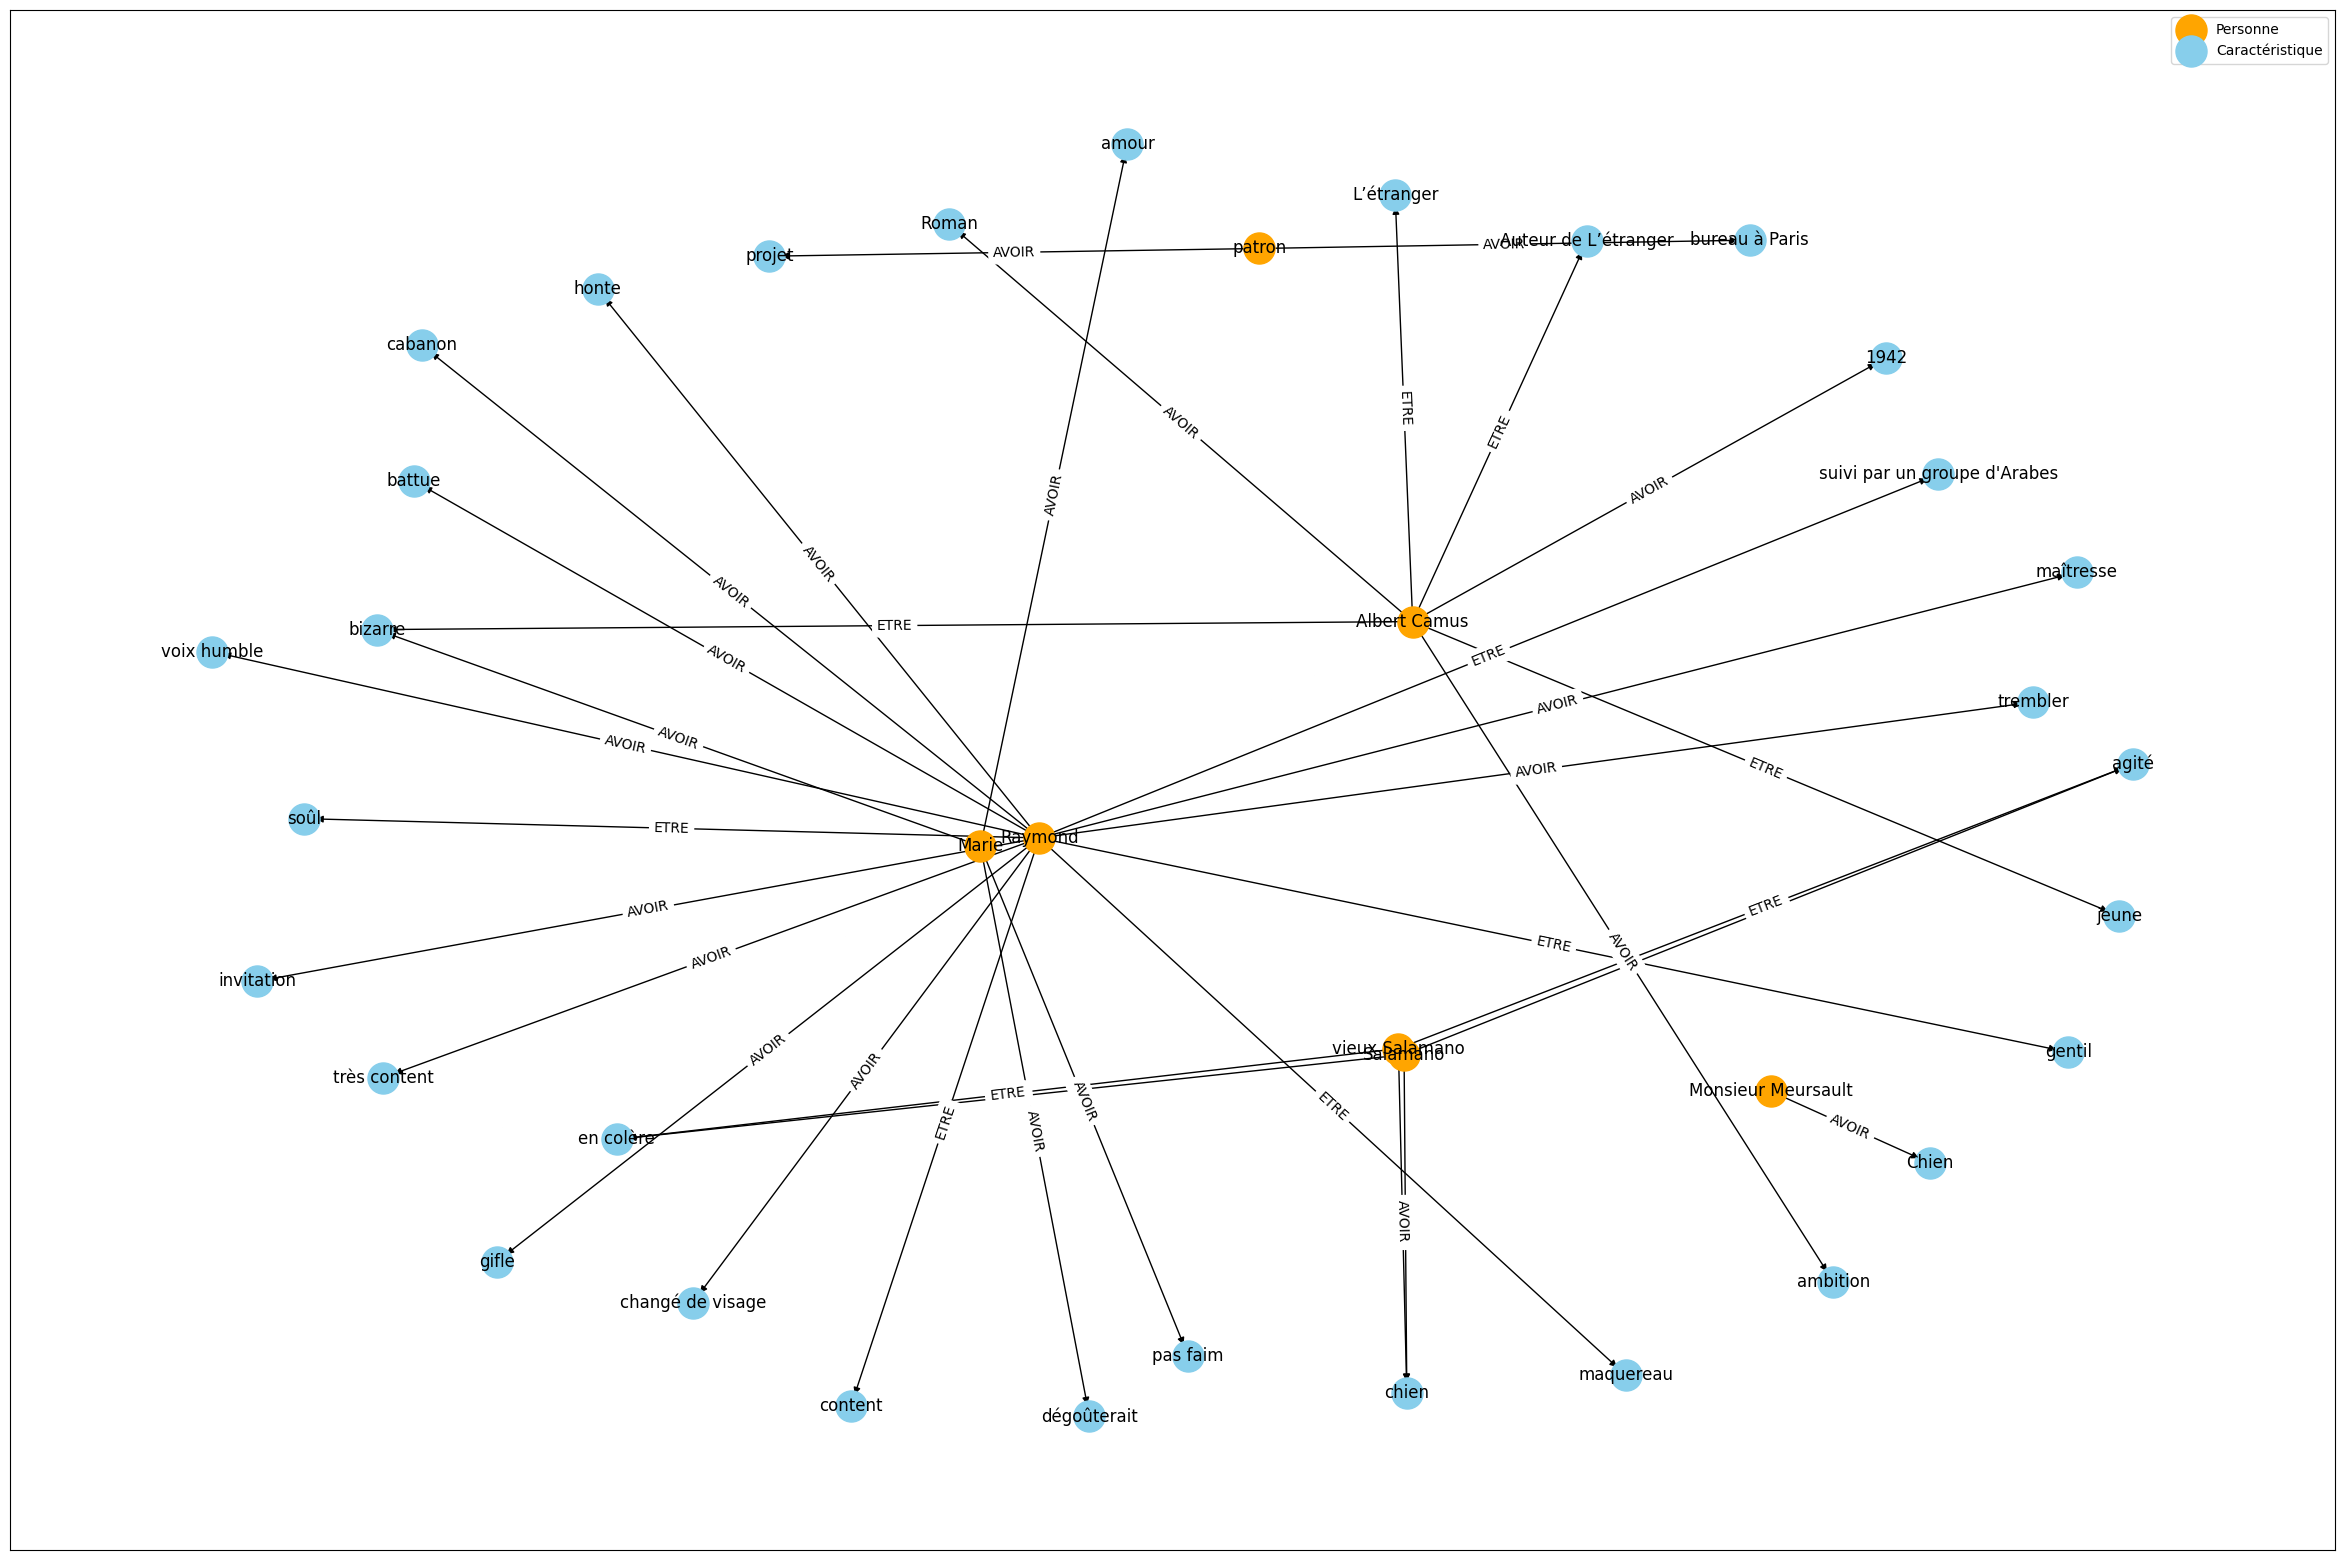

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

# Define node and relationship types
NODE_NAME = "Personne"
RELATIONSHIP_NAME1 = "AVOIR"
RELATIONSHIP_NAME2 = "ETRE"
FEATURE_NAME = "Caractéristique"

def visualize_data():
    query = f"""
    MATCH (p:{NODE_NAME})-[r:{RELATIONSHIP_NAME1}]->(f:{FEATURE_NAME}) 
    RETURN p, r, f
    UNION
    MATCH (p:{NODE_NAME})-[r:{RELATIONSHIP_NAME2}]->(f:{FEATURE_NAME})
    RETURN p, r, f
    """

    records, summary, keys = driver.execute_query(query)

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges
    for record in records:
        person = record["p"]
        feature = record["f"]
        relationship = record["r"]
        
        G.add_node(person['id'], label='Personne', node_type='Personne')
        G.add_node(feature['id'], label='Caractéristique', node_type='Caractéristique')
        
        # Determine relationship type and add edge
        if relationship.type == RELATIONSHIP_NAME1:
            G.add_edge(person['id'], feature['id'], relationship=RELATIONSHIP_NAME1)
        elif relationship.type == RELATIONSHIP_NAME2:
            G.add_edge(person['id'], feature['id'], relationship=RELATIONSHIP_NAME2)

    # Get positions for the nodes
    pos = nx.spring_layout(G)

    # Increase the figure size for better display
    plt.figure(figsize=(30, 20))

    # Draw nodes with different colors based on their type
    person_nodes = [n for n, d in G.nodes(data=True) if d['node_type'] == 'Personne']
    feature_nodes = [n for n, d in G.nodes(data=True) if d['node_type'] == 'Caractéristique']

    nx.draw_networkx_nodes(G, pos, nodelist=person_nodes, node_color='orange', node_size=500, label='Personne')
    nx.draw_networkx_nodes(G, pos, nodelist=feature_nodes, node_color='skyblue', node_size=500, label='Caractéristique')

    # Draw edges
    nx.draw_networkx_edges(G, pos)

    # Draw labels
    labels = nx.get_edge_attributes(G, 'relationship')
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    # Add a legend
    plt.legend(['Personne', 'Caractéristique'])
    plt.show()

# Visualize the data
visualize_data()

# Close the driver connection
driver.close()
